In [1]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json

In [2]:
warnings.filterwarnings('ignore', 'No format checks')

In [43]:
path = 'wqq_control/'

In [44]:
arr = {}
files = os.listdir(f'{path}')
for i in files:
    if 'wqq' in i:
        arr[i.rstrip('.parquet')] = ak.from_parquet(f'{path}/{i}')

In [45]:
arr

{'wqq_200to400': <Array [{pfcand_eta: [...], ...}] type='1 * {pfcand_eta: var * ?float32, pf...'>,
 'wqq_400to600': <Array [{pfcand_eta: [...], ...}, ..., {...}] type='24 * {pfcand_eta: var *...'>,
 'wqq_600to800': <Array [{pfcand_eta: [...], ...}, ..., {...}] type='10038 * {pfcand_eta: va...'>,
 'wqq_800toInf': <Array [{pfcand_eta: [...], ...}, ..., {...}] type='901682 * {pfcand_eta: v...'>}

In [11]:
def nan_remover(sample):
    if type(sample) == dict:
        for j in sample:
            mask = ak.ones_like(sample[j][sample[j].fields[0]], dtype='bool')
            mask = ak.fill_none(mask, True)
            for k in sample[j].fields:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
            sample[j] = sample[j][mask]
    else:
        mask = ak.ones_like(sample[sample.fields[0]], dtype='bool')
        mask = ak.fill_none(mask, True)
        for j in sample.fields:
            if sample[j].fields == []:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j])))
            else:
                for k in sample[j].fields:
                    mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
        sample = sample[mask]
    return mask

In [13]:
for i in arr:
    arr[i] = arr[i][arr[i].fj_sdmass <= 170]
    arr[i] = arr[i][arr[i].fj_sdmass >= 80]
    arr[i] = arr[i][arr[i].fj_pt >= 450]
    arr[i] = arr[i][arr[i].fj_pt <= 600]

In [14]:
# for i in qcd:
#     mask = (nan_remover(qcd[i]))
#     qcd[i] = qcd[i][mask]

In [23]:
IL = 44.99
xsec = {}
xsec['qcd_300to470'] = 1400 #6833
xsec['qcd_470to600'] = 549.5
xsec['qcd_600to800'] = 156.5
xsec['qcd_800to1000'] = 26.22
xsec['qcd_1000to1400'] = 7.475
xsec['qcd_1400to1800'] = 0.6482
xsec['qcd_1800to2400'] = 0.08742
xsec['qcd_2400to3200'] = 0.005237
xsec['qcd_3200toInf'] = 0.0001353

In [24]:
qcd_frac = {}
for i in arr:
    qcd_frac[i] = ((xsec[i]*1000)*IL)/len(qcd[i])
qcd_frac['tot'] = sum(qcd_frac.values())
sval = {}
for i in arr:
    sval[i] = qcd_frac[i]/qcd_frac['tot']
combed = {}
for i in arr:
    temp = arr[i]
    combed[i] = temp[np.random.rand(len(temp)) < sval[i]]
qcd_stitched = ak.concatenate([combed[x] for x in combed])

In [36]:
qcd_msd = qcd_stitched.fj_sdmass
qcd_stitched_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='QCD MSD').Weight()
qcd_stitched_hist.fill(msd=qcd_msd);

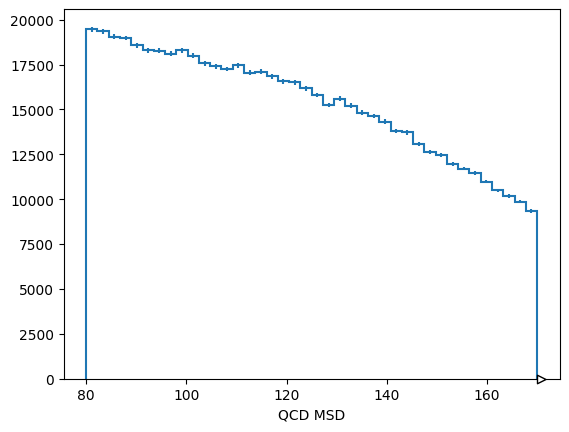

In [37]:
qcd_stitched_hist.plot1d()
plt.show()

In [46]:
qcd_hist_dict = {}
for i in arr:
    temp_qcd_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='QCD MSD').Weight()
    temp_qcd_hist.fill(msd=arr[i].fj_sdmass);
    qcd_hist_dict[i] = temp_qcd_hist

In [39]:
path = '/scratch365/cmoore24/training/hgg/batch/ml_results_checking'
with open(f'{path}/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)
del(totals['ww4q'])

In [40]:
with open(f'{path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [41]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2

In [42]:
totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

In [43]:
for i in qcd_hist_dict:
    scale = ((44.99*(xsecs[i]*1000))/totals[i])
    qcd_hist_dict[i].view(flow=True)[:] *= scale

In [47]:
qcd_hist = sum(value for key, value in qcd_hist_dict.items())

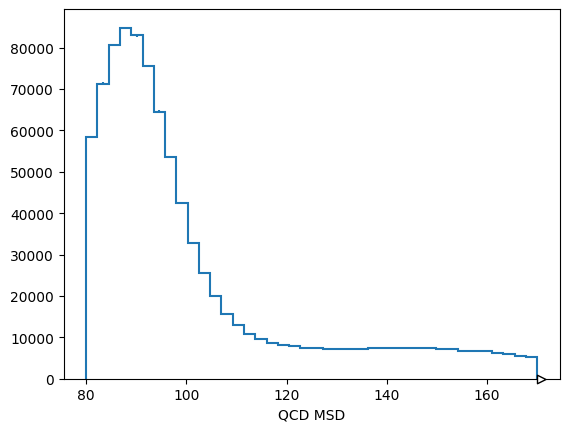

In [48]:
qcd_hist.plot1d()
plt.show()

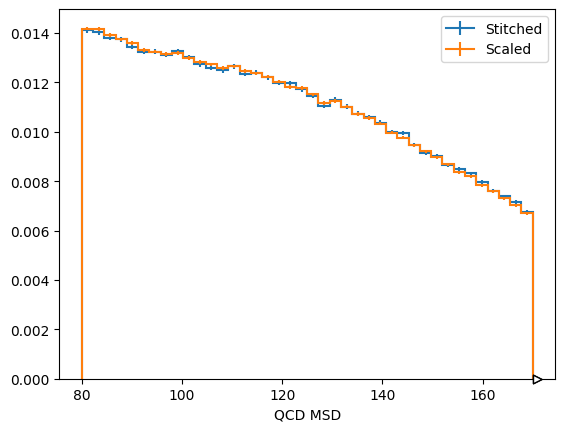

In [46]:
qcd_stitched_hist.plot1d(density=True, label='Stitched')
qcd_hist.plot1d(density=True, label='Scaled')
plt.legend()
plt.show()

In [3]:
hgg = ak.from_parquet('hgg/hgg_regular/*')
qcd = ak.from_parquet('qcd/qcd_totrain/*')
#wqq = ak.from_parquet('wqq_totrain/*')

In [4]:
hgg = ak.concatenate([hgg, qcd])

In [5]:
hgg = ak.concatenate([arr[i] for i in arr])

NameError: name 'arr' is not defined

In [6]:
import math
size = math.floor(len(hgg)/6)

In [7]:
i1 = size
i2 = size * 2
i3 = size * 3
i4 = size * 4
i5 = size * 5
i6 = size * 6

In [8]:
shuffle = np.random.permutation(len(hgg))
hgg = hgg[shuffle]

In [9]:
hgg[5].label_H_gg

0.0

In [10]:
one = hgg[:i1]
two = hgg[i1:i2]
three = hgg[i2:i3]
four = hgg[i3:i4]
five = hgg[i4:i5]
six = hgg[i5:]

In [16]:
ak.to_parquet(six, 'all_classes/hgg_qcd/six.parquet')

  created_by: parquet-cpp-arrow version 17.0.0
  num_columns: 21
  num_rows: 109554
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [141]:
len(qcd_stitched)

823422